In [2]:
import os
import numpy as np
import btrack
import glob
import zipfile
import pandas as pd
# from ijroi import ROI
from tqdm.auto import tqdm
import csv
import cv2


In [3]:
df = pd.read_pickle('/mnt/SYNO/macrohet_syno/manuscript/results/dt_df.pkl')

In [4]:
# Iterate over the expt_IDs
for expt_ID in ['PS0000', 'ND0002', 'ND0003']:
    subset_df = df[df['Experiment ID'] == expt_ID]
    subset_df = subset_df[subset_df['Time (hours)'] == subset_df['Time (hours)'].max()]
    acq_IDs = subset_df['Acquisition ID'].unique()

    for acq_ID in acq_IDs:
        seg_fn = glob.glob(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/*/{acq_ID}.h5'))[0]
        # Read the segmentation and tracks
        with btrack.io.HDF5FileHandler(seg_fn, 'r', obj_type='obj_type_1') as reader:
            segmentation = reader.segmentation[-1]

        break
    break

[INFO][2024/06/03 02:51:47 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2024/06/03 02:51:57 PM] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 02:51:57 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5


In [24]:
unique_values

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [38]:
from skimage import measure


In [51]:
unique_values = np.unique(segmentation)
shape_coordinates = {}

for value in tqdm(unique_values):
    if value == 0:  # Assuming 0 is the background
        continue
    
    coordinates = np.argwhere(segmentation == value)
    shape_coordinates[value] = coordinates

  0%|          | 0/2 [00:00<?, ?it/s]

In [52]:
len(coordinates)

2231

In [117]:
# Iterate over the expt_IDs
for expt_ID in tqdm(['PS0000', 'ND0002', 'ND0003']):
    subset_df = df[df['Experiment ID'] == expt_ID]
    subset_df = subset_df[subset_df['Time (hours)'] == subset_df['Time (hours)'].max()]
    acq_IDs = subset_df['Acquisition ID'].unique()

    for acq_ID in tqdm(acq_IDs, total = len(acq_IDs)):
        # make output directory 
        output_directory = f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/roi/{acq_ID}'
        os.makedirs(output_directory, exist_ok=True)

        # load tracks
        seg_fn = glob.glob(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/*/{acq_ID}.h5'))[0]
        # Read the segmentation and tracks
        with btrack.io.HDF5FileHandler(seg_fn, 'r', obj_type='obj_type_1') as reader:
            segmentation = reader.segmentation
            tracks = [t for t in reader.tracks if t.in_frame(len(segmentation)-1)]
        segmentation_array = segmentation[-1]        
       
        ordered_boundary_coordinates = {}
        for track in tqdm(tracks, leave = False, desc = 'Iterating over tracks'):
            # get the last coords of track
            x, y = int(track.x[-1]*scale_factor), int(track.y[-1]*scale_factor)
        
            # Get the value of the segment at the coordinates
            value = segmentation_array[y, x]
        
            if value == 0:  # Assuming 0 is the background
                continue
            
            # Create a binary mask for the current value
            binary_mask = segmentation_array == value
            
            # Find the contours of the binary mask
            contours = measure.find_contours(binary_mask, 0.5)
            
            # Use only the largest contour to represent the boundary
            largest_contour = max(contours, key=len)
            
            # Convert contour to integer coordinates and ensure uniqueness
            boundary_coords = np.round(largest_contour).astype(int)
            
            # Ensure the boundary coordinates form a closed loop
            if not np.array_equal(boundary_coords[0], boundary_coords[-1]):
                boundary_coords = np.vstack([boundary_coords, boundary_coords[0]])
        
            # find if there is a cell ID associated with 
            # Format the coordinates with leading zeros
            x_str = f'{x:04d}'
            y_str = f'{y:04d}'
            
            # Save the boundary coordinates as an ROI file with formatted name
            roi_filename = f'{track.ID}_{x_str}_{y_str}.roi'
            roi_path = os.path.join(output_directory, roi_filename)
            ImagejRoi.frompoints(boundary_coords).tofile(roi_path)


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2024/06/03 05:52:56 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2024/06/03 05:53:06 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 05:53:06 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 05:53:06 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 05:53:06 pm] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2024/06/03 05:53:07 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5


Iterating over tracks:   0%|          | 0/465 [00:00<?, ?it/s]

[INFO][2024/06/03 05:56:07 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 5).h5...
[INFO][2024/06/03 05:56:17 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 05:56:17 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 05:56:17 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 05:56:17 pm] Loading objects/obj_type_1 (41424, 5) (41424 filtered: None)
[INFO][2024/06/03 05:56:18 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 5).h5


Iterating over tracks:   0%|          | 0/462 [00:00<?, ?it/s]

[INFO][2024/06/03 05:59:11 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 6).h5...
[INFO][2024/06/03 05:59:21 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 05:59:21 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 05:59:21 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 05:59:22 pm] Loading objects/obj_type_1 (46507, 5) (46507 filtered: None)
[INFO][2024/06/03 05:59:22 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 6).h5


Iterating over tracks:   0%|          | 0/612 [00:00<?, ?it/s]

[INFO][2024/06/03 06:03:15 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 7).h5...
[INFO][2024/06/03 06:03:26 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 06:03:26 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 06:03:26 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 06:03:26 pm] Loading objects/obj_type_1 (42503, 5) (42503 filtered: None)
[INFO][2024/06/03 06:03:26 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 7).h5


Iterating over tracks:   0%|          | 0/517 [00:00<?, ?it/s]

[INFO][2024/06/03 06:06:53 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 8).h5...
[INFO][2024/06/03 06:07:03 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 06:07:03 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 06:07:03 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 06:07:03 pm] Loading objects/obj_type_1 (47396, 5) (47396 filtered: None)
[INFO][2024/06/03 06:07:04 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 8).h5


Iterating over tracks:   0%|          | 0/613 [00:00<?, ?it/s]

[INFO][2024/06/03 06:11:16 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 9).h5...
[INFO][2024/06/03 06:11:26 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 06:11:26 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 06:11:26 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 06:11:26 pm] Loading objects/obj_type_1 (42259, 5) (42259 filtered: None)
[INFO][2024/06/03 06:11:27 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 9).h5


Iterating over tracks:   0%|          | 0/533 [00:00<?, ?it/s]

[INFO][2024/06/03 06:15:12 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 4).h5...
[INFO][2024/06/03 06:15:23 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 06:15:23 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 06:15:23 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 06:15:23 pm] Loading objects/obj_type_1 (41640, 5) (41640 filtered: None)
[INFO][2024/06/03 06:15:24 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 4).h5


Iterating over tracks:   0%|          | 0/502 [00:00<?, ?it/s]

[INFO][2024/06/03 06:18:50 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 5).h5...
[INFO][2024/06/03 06:18:59 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 06:18:59 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 06:18:59 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 06:18:59 pm] Loading objects/obj_type_1 (47242, 5) (47242 filtered: None)
[INFO][2024/06/03 06:19:00 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 5).h5


Iterating over tracks:   0%|          | 0/451 [00:00<?, ?it/s]

[INFO][2024/06/03 06:22:02 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 6).h5...
[INFO][2024/06/03 06:22:13 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 06:22:13 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 06:22:13 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 06:22:13 pm] Loading objects/obj_type_1 (43883, 5) (43883 filtered: None)
[INFO][2024/06/03 06:22:13 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 6).h5


Iterating over tracks:   0%|          | 0/504 [00:00<?, ?it/s]

[INFO][2024/06/03 06:25:39 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 7).h5...
[INFO][2024/06/03 06:25:49 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 06:25:49 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 06:25:49 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 06:25:50 pm] Loading objects/obj_type_1 (42965, 5) (42965 filtered: None)
[INFO][2024/06/03 06:25:51 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 7).h5


Iterating over tracks:   0%|          | 0/491 [00:00<?, ?it/s]

[INFO][2024/06/03 06:29:13 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 8).h5...
[INFO][2024/06/03 07:22:29 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:22:29 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:22:29 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:22:29 pm] Loading objects/obj_type_1 (38895, 5) (38895 filtered: None)
[INFO][2024/06/03 07:22:30 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 8).h5


Iterating over tracks:   0%|          | 0/450 [00:00<?, ?it/s]

[INFO][2024/06/03 07:25:36 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 9).h5...
[INFO][2024/06/03 07:25:46 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:25:46 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:25:46 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:25:46 pm] Loading objects/obj_type_1 (44643, 5) (44643 filtered: None)
[INFO][2024/06/03 07:25:47 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(4, 9).h5


Iterating over tracks:   0%|          | 0/518 [00:00<?, ?it/s]

[INFO][2024/06/03 07:29:06 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 4).h5...
[INFO][2024/06/03 07:29:16 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:29:16 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:29:16 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:29:16 pm] Loading objects/obj_type_1 (30664, 5) (30664 filtered: None)
[INFO][2024/06/03 07:29:17 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 4).h5


Iterating over tracks:   0%|          | 0/334 [00:00<?, ?it/s]

[INFO][2024/06/03 07:31:30 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 5).h5...
[INFO][2024/06/03 07:31:43 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:31:43 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:31:43 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:31:43 pm] Loading objects/obj_type_1 (42973, 5) (42973 filtered: None)
[INFO][2024/06/03 07:31:44 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 5).h5


Iterating over tracks:   0%|          | 0/454 [00:00<?, ?it/s]

[INFO][2024/06/03 07:34:45 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 6).h5...
[INFO][2024/06/03 07:34:55 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:34:55 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:34:55 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:34:55 pm] Loading objects/obj_type_1 (45678, 5) (45678 filtered: None)
[INFO][2024/06/03 07:34:56 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 6).h5


Iterating over tracks:   0%|          | 0/549 [00:00<?, ?it/s]

[INFO][2024/06/03 07:38:30 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 7).h5...
[INFO][2024/06/03 07:38:41 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:38:41 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:38:41 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:38:41 pm] Loading objects/obj_type_1 (47880, 5) (47880 filtered: None)
[INFO][2024/06/03 07:38:42 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 7).h5


Iterating over tracks:   0%|          | 0/614 [00:00<?, ?it/s]

[INFO][2024/06/03 07:42:50 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 8).h5...
[INFO][2024/06/03 07:43:01 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:43:01 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:43:01 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:43:02 pm] Loading objects/obj_type_1 (38531, 5) (38531 filtered: None)
[INFO][2024/06/03 07:43:02 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 8).h5


Iterating over tracks:   0%|          | 0/454 [00:00<?, ?it/s]

[INFO][2024/06/03 07:45:59 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 9).h5...
[INFO][2024/06/03 07:46:09 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:46:09 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:46:09 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:46:09 pm] Loading objects/obj_type_1 (33081, 5) (33081 filtered: None)
[INFO][2024/06/03 07:46:10 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(5, 9).h5


Iterating over tracks:   0%|          | 0/177 [00:00<?, ?it/s]

[INFO][2024/06/03 07:47:18 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 4).h5...
[INFO][2024/06/03 07:47:28 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:47:28 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:47:28 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:47:28 pm] Loading objects/obj_type_1 (42961, 5) (42961 filtered: None)
[INFO][2024/06/03 07:47:29 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 4).h5


Iterating over tracks:   0%|          | 0/491 [00:00<?, ?it/s]

[INFO][2024/06/03 07:51:30 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 5).h5...
[INFO][2024/06/03 07:51:40 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:51:40 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:51:40 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:51:40 pm] Loading objects/obj_type_1 (46808, 5) (46808 filtered: None)
[INFO][2024/06/03 07:51:41 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 5).h5


Iterating over tracks:   0%|          | 0/513 [00:00<?, ?it/s]

[INFO][2024/06/03 07:55:06 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 6).h5...
[INFO][2024/06/03 07:55:15 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:55:15 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:55:15 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:55:15 pm] Loading objects/obj_type_1 (45688, 5) (45688 filtered: None)
[INFO][2024/06/03 07:55:15 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 6).h5


Iterating over tracks:   0%|          | 0/547 [00:00<?, ?it/s]

[INFO][2024/06/03 07:58:47 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 7).h5...
[INFO][2024/06/03 07:58:58 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 07:58:58 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 07:58:58 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 07:58:58 pm] Loading objects/obj_type_1 (45214, 5) (45214 filtered: None)
[INFO][2024/06/03 07:58:59 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 7).h5


Iterating over tracks:   0%|          | 0/570 [00:00<?, ?it/s]

[INFO][2024/06/03 08:02:56 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 8).h5...
[INFO][2024/06/03 08:03:05 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 08:03:05 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 08:03:05 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 08:03:05 pm] Loading objects/obj_type_1 (46267, 5) (46267 filtered: None)
[INFO][2024/06/03 08:03:06 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 8).h5


Iterating over tracks:   0%|          | 0/547 [00:00<?, ?it/s]

[INFO][2024/06/03 08:06:52 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 9).h5...
[INFO][2024/06/03 08:07:02 pm] Loading segmentation (75, 6048, 6048)
[INFO][2024/06/03 08:07:02 pm] Loading tracks/obj_type_1
[INFO][2024/06/03 08:07:02 pm] Loading LBEP/obj_type_1
[INFO][2024/06/03 08:07:02 pm] Loading objects/obj_type_1 (35615, 5) (35615 filtered: None)
[INFO][2024/06/03 08:07:03 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(6, 9).h5


Iterating over tracks:   0%|          | 0/239 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

[INFO][2024/06/04 09:21:31 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 1).h5...
[INFO][2024/06/04 09:21:54 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:21:54 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:21:54 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:21:54 am] Loading objects/obj_type_1 (15525, 5) (15525 filtered: None)
[INFO][2024/06/04 09:21:54 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 1).h5


Iterating over tracks:   0%|          | 0/95 [00:00<?, ?it/s]

[INFO][2024/06/04 09:22:36 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 2).h5...
[INFO][2024/06/04 09:22:58 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:22:58 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:22:58 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:22:58 am] Loading objects/obj_type_1 (15189, 5) (15189 filtered: None)
[INFO][2024/06/04 09:22:59 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 2).h5


Iterating over tracks:   0%|          | 0/103 [00:00<?, ?it/s]

[INFO][2024/06/04 09:23:44 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 3).h5...
[INFO][2024/06/04 09:24:09 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:24:09 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:24:09 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:24:09 am] Loading objects/obj_type_1 (27753, 5) (27753 filtered: None)
[INFO][2024/06/04 09:24:10 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 3).h5


Iterating over tracks:   0%|          | 0/185 [00:00<?, ?it/s]

[INFO][2024/06/04 09:25:32 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 4).h5...
[INFO][2024/06/04 09:25:54 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:25:54 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:25:54 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:25:54 am] Loading objects/obj_type_1 (26949, 5) (26949 filtered: None)
[INFO][2024/06/04 09:25:55 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 4).h5


Iterating over tracks:   0%|          | 0/183 [00:00<?, ?it/s]

[INFO][2024/06/04 09:27:13 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 5).h5...
[INFO][2024/06/04 09:27:36 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:27:36 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:27:36 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:27:36 am] Loading objects/obj_type_1 (26113, 5) (26113 filtered: None)
[INFO][2024/06/04 09:27:37 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 5).h5


Iterating over tracks:   0%|          | 0/190 [00:00<?, ?it/s]

[INFO][2024/06/04 09:28:55 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 6).h5...
[INFO][2024/06/04 09:29:17 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:29:17 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:29:18 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:29:18 am] Loading objects/obj_type_1 (27965, 5) (27965 filtered: None)
[INFO][2024/06/04 09:29:18 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 6).h5


Iterating over tracks:   0%|          | 0/239 [00:00<?, ?it/s]

[INFO][2024/06/04 09:30:57 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 7).h5...
[INFO][2024/06/04 09:31:19 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:31:19 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:31:19 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:31:19 am] Loading objects/obj_type_1 (15392, 5) (15392 filtered: None)
[INFO][2024/06/04 09:31:19 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 7).h5


Iterating over tracks:   0%|          | 0/67 [00:00<?, ?it/s]

[INFO][2024/06/04 09:31:47 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 8).h5...
[INFO][2024/06/04 09:32:08 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:32:08 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:32:08 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:32:08 am] Loading objects/obj_type_1 (17939, 5) (17939 filtered: None)
[INFO][2024/06/04 09:32:09 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 8).h5


Iterating over tracks:   0%|          | 0/104 [00:00<?, ?it/s]

[INFO][2024/06/04 09:32:48 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 9).h5...
[INFO][2024/06/04 09:33:10 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:33:10 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:33:10 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:33:11 am] Loading objects/obj_type_1 (20179, 5) (20179 filtered: None)
[INFO][2024/06/04 09:33:11 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 9).h5


Iterating over tracks:   0%|          | 0/126 [00:00<?, ?it/s]

[INFO][2024/06/04 09:34:03 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 10).h5...
[INFO][2024/06/04 09:34:25 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:34:25 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:34:25 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:34:25 am] Loading objects/obj_type_1 (14083, 5) (14083 filtered: None)
[INFO][2024/06/04 09:34:26 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 10).h5


Iterating over tracks:   0%|          | 0/76 [00:00<?, ?it/s]

[INFO][2024/06/04 09:34:56 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 11).h5...
[INFO][2024/06/04 09:35:19 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:35:19 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:35:19 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:35:19 am] Loading objects/obj_type_1 (12685, 5) (12685 filtered: None)
[INFO][2024/06/04 09:35:20 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 11).h5


Iterating over tracks:   0%|          | 0/106 [00:00<?, ?it/s]

[INFO][2024/06/04 09:36:03 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 12).h5...
[INFO][2024/06/04 09:36:27 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:36:27 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:36:27 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:36:27 am] Loading objects/obj_type_1 (8336, 5) (8336 filtered: None)
[INFO][2024/06/04 09:36:27 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(3, 12).h5


Iterating over tracks:   0%|          | 0/74 [00:00<?, ?it/s]

[INFO][2024/06/04 09:36:58 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 3).h5...
[INFO][2024/06/04 09:37:19 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:37:19 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:37:19 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:37:19 am] Loading objects/obj_type_1 (27621, 5) (27621 filtered: None)
[INFO][2024/06/04 09:37:20 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 3).h5


Iterating over tracks:   0%|          | 0/222 [00:00<?, ?it/s]

[INFO][2024/06/04 09:38:51 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 4).h5...
[INFO][2024/06/04 09:39:12 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:39:12 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:39:12 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:39:13 am] Loading objects/obj_type_1 (27406, 5) (27406 filtered: None)
[INFO][2024/06/04 09:39:13 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 4).h5


Iterating over tracks:   0%|          | 0/212 [00:00<?, ?it/s]

[INFO][2024/06/04 09:40:36 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 5).h5...
[INFO][2024/06/04 09:41:00 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:41:00 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:41:00 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:41:00 am] Loading objects/obj_type_1 (24771, 5) (24771 filtered: None)
[INFO][2024/06/04 09:41:01 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 5).h5


Iterating over tracks:   0%|          | 0/169 [00:00<?, ?it/s]

[INFO][2024/06/04 09:42:14 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 6).h5...
[INFO][2024/06/04 09:42:36 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:42:36 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:42:36 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:42:37 am] Loading objects/obj_type_1 (26391, 5) (26391 filtered: None)
[INFO][2024/06/04 09:42:37 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 6).h5


Iterating over tracks:   0%|          | 0/204 [00:00<?, ?it/s]

[INFO][2024/06/04 09:44:01 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 7).h5...
[INFO][2024/06/04 09:44:22 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:44:22 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:44:22 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:44:23 am] Loading objects/obj_type_1 (23239, 5) (23239 filtered: None)
[INFO][2024/06/04 09:44:23 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 7).h5


Iterating over tracks:   0%|          | 0/154 [00:00<?, ?it/s]

[INFO][2024/06/04 09:45:28 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 8).h5...
[INFO][2024/06/04 09:45:51 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:45:51 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:45:51 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:45:51 am] Loading objects/obj_type_1 (22597, 5) (22597 filtered: None)
[INFO][2024/06/04 09:45:51 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 8).h5


Iterating over tracks:   0%|          | 0/138 [00:00<?, ?it/s]

[INFO][2024/06/04 09:46:49 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 9).h5...
[INFO][2024/06/04 09:47:15 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:47:15 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:47:15 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:47:15 am] Loading objects/obj_type_1 (24136, 5) (24136 filtered: None)
[INFO][2024/06/04 09:47:16 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 9).h5


Iterating over tracks:   0%|          | 0/126 [00:00<?, ?it/s]

[INFO][2024/06/04 09:48:10 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 10).h5...
[INFO][2024/06/04 09:48:31 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:48:31 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:48:31 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:48:31 am] Loading objects/obj_type_1 (22088, 5) (22088 filtered: None)
[INFO][2024/06/04 09:48:32 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 10).h5


Iterating over tracks:   0%|          | 0/103 [00:00<?, ?it/s]

[INFO][2024/06/04 09:49:16 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 11).h5...
[INFO][2024/06/04 09:49:39 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:49:39 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:49:39 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:49:39 am] Loading objects/obj_type_1 (14929, 5) (14929 filtered: None)
[INFO][2024/06/04 09:49:39 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 11).h5


Iterating over tracks:   0%|          | 0/95 [00:00<?, ?it/s]

[INFO][2024/06/04 09:50:20 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 12).h5...
[INFO][2024/06/04 09:50:43 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:50:43 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:50:43 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:50:44 am] Loading objects/obj_type_1 (12150, 5) (12150 filtered: None)
[INFO][2024/06/04 09:50:44 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(4, 12).h5


Iterating over tracks:   0%|          | 0/66 [00:00<?, ?it/s]

[INFO][2024/06/04 09:51:10 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 3).h5...
[INFO][2024/06/04 09:51:32 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:51:32 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:51:32 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:51:33 am] Loading objects/obj_type_1 (17399, 5) (17399 filtered: None)
[INFO][2024/06/04 09:51:33 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 3).h5


Iterating over tracks:   0%|          | 0/96 [00:00<?, ?it/s]

[INFO][2024/06/04 09:52:13 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 4).h5...
[INFO][2024/06/04 09:52:35 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:52:35 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:52:35 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:52:35 am] Loading objects/obj_type_1 (16764, 5) (16764 filtered: None)
[INFO][2024/06/04 09:52:35 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 4).h5


Iterating over tracks:   0%|          | 0/92 [00:00<?, ?it/s]

[INFO][2024/06/04 09:53:13 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 5).h5...
[INFO][2024/06/04 09:53:35 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:53:35 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:53:35 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:53:35 am] Loading objects/obj_type_1 (18133, 5) (18133 filtered: None)
[INFO][2024/06/04 09:53:35 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 5).h5


Iterating over tracks:   0%|          | 0/112 [00:00<?, ?it/s]

[INFO][2024/06/04 09:54:22 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 6).h5...
[INFO][2024/06/04 09:54:45 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:54:45 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:54:45 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:54:46 am] Loading objects/obj_type_1 (13392, 5) (13392 filtered: None)
[INFO][2024/06/04 09:54:46 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 6).h5


Iterating over tracks:   0%|          | 0/76 [00:00<?, ?it/s]

[INFO][2024/06/04 09:55:16 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 7).h5...
[INFO][2024/06/04 09:55:40 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:55:40 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:55:40 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:55:40 am] Loading objects/obj_type_1 (14723, 5) (14723 filtered: None)
[INFO][2024/06/04 09:55:40 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 7).h5


Iterating over tracks:   0%|          | 0/93 [00:00<?, ?it/s]

[INFO][2024/06/04 09:56:17 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 8).h5...
[INFO][2024/06/04 09:56:40 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:56:40 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:56:40 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:56:40 am] Loading objects/obj_type_1 (14960, 5) (14960 filtered: None)
[INFO][2024/06/04 09:56:40 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 8).h5


Iterating over tracks:   0%|          | 0/78 [00:00<?, ?it/s]

[INFO][2024/06/04 09:57:13 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 9).h5...
[INFO][2024/06/04 09:57:36 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:57:36 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:57:36 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:57:36 am] Loading objects/obj_type_1 (14153, 5) (14153 filtered: None)
[INFO][2024/06/04 09:57:37 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 9).h5


Iterating over tracks:   0%|          | 0/68 [00:00<?, ?it/s]

[INFO][2024/06/04 09:58:04 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 10).h5...
[INFO][2024/06/04 09:58:26 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:58:26 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:58:26 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:58:26 am] Loading objects/obj_type_1 (15564, 5) (15564 filtered: None)
[INFO][2024/06/04 09:58:26 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 10).h5


Iterating over tracks:   0%|          | 0/81 [00:00<?, ?it/s]

[INFO][2024/06/04 09:59:01 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 11).h5...
[INFO][2024/06/04 09:59:25 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 09:59:25 am] Loading tracks/obj_type_1
[INFO][2024/06/04 09:59:25 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 09:59:25 am] Loading objects/obj_type_1 (10982, 5) (10982 filtered: None)
[INFO][2024/06/04 09:59:25 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 11).h5


Iterating over tracks:   0%|          | 0/72 [00:00<?, ?it/s]

[INFO][2024/06/04 09:59:52 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 12).h5...
[INFO][2024/06/04 10:00:14 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:00:14 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:00:14 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:00:14 am] Loading objects/obj_type_1 (11181, 5) (11181 filtered: None)
[INFO][2024/06/04 10:00:14 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(5, 12).h5


Iterating over tracks:   0%|          | 0/80 [00:00<?, ?it/s]

[INFO][2024/06/04 10:00:46 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 4).h5...
[INFO][2024/06/04 10:01:10 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:01:10 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:01:10 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:01:10 am] Loading objects/obj_type_1 (14778, 5) (14778 filtered: None)
[INFO][2024/06/04 10:01:10 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 4).h5


Iterating over tracks:   0%|          | 0/108 [00:00<?, ?it/s]

[INFO][2024/06/04 10:01:52 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 5).h5...
[INFO][2024/06/04 10:02:15 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:02:15 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:02:15 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:02:15 am] Loading objects/obj_type_1 (12221, 5) (12221 filtered: None)
[INFO][2024/06/04 10:02:15 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 5).h5


Iterating over tracks:   0%|          | 0/63 [00:00<?, ?it/s]

[INFO][2024/06/04 10:02:41 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 6).h5...
[INFO][2024/06/04 10:03:04 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:03:04 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:03:04 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:03:05 am] Loading objects/obj_type_1 (14495, 5) (14495 filtered: None)
[INFO][2024/06/04 10:03:05 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 6).h5


Iterating over tracks:   0%|          | 0/89 [00:00<?, ?it/s]

[INFO][2024/06/04 10:03:41 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 7).h5...
[INFO][2024/06/04 10:04:03 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:04:03 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:04:03 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:04:03 am] Loading objects/obj_type_1 (10557, 5) (10557 filtered: None)
[INFO][2024/06/04 10:04:04 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 7).h5


Iterating over tracks:   0%|          | 0/84 [00:00<?, ?it/s]

[INFO][2024/06/04 10:04:37 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 8).h5...
[INFO][2024/06/04 10:05:00 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:05:00 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:05:00 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:05:00 am] Loading objects/obj_type_1 (11790, 5) (11790 filtered: None)
[INFO][2024/06/04 10:05:00 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 8).h5


Iterating over tracks:   0%|          | 0/59 [00:00<?, ?it/s]

[INFO][2024/06/04 10:05:25 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 9).h5...
[INFO][2024/06/04 10:05:47 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:05:47 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:05:47 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:05:48 am] Loading objects/obj_type_1 (10973, 5) (10973 filtered: None)
[INFO][2024/06/04 10:05:48 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 9).h5


Iterating over tracks:   0%|          | 0/81 [00:00<?, ?it/s]

[INFO][2024/06/04 10:06:20 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 10).h5...
[INFO][2024/06/04 10:06:44 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:06:44 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:06:44 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:06:44 am] Loading objects/obj_type_1 (10327, 5) (10327 filtered: None)
[INFO][2024/06/04 10:06:44 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 10).h5


Iterating over tracks:   0%|          | 0/63 [00:00<?, ?it/s]

[INFO][2024/06/04 10:07:07 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 11).h5...
[INFO][2024/06/04 10:07:30 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:07:30 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:07:30 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:07:30 am] Loading objects/obj_type_1 (11127, 5) (11127 filtered: None)
[INFO][2024/06/04 10:07:30 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 11).h5


Iterating over tracks:   0%|          | 0/61 [00:00<?, ?it/s]

[INFO][2024/06/04 10:07:54 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 12).h5...
[INFO][2024/06/04 10:08:17 am] Loading segmentation (150, 6048, 6048)
[INFO][2024/06/04 10:08:17 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:08:17 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:08:17 am] Loading objects/obj_type_1 (10838, 5) (10838 filtered: None)
[INFO][2024/06/04 10:08:17 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0002/labels/cpv3/(6, 12).h5


Iterating over tracks:   0%|          | 0/59 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

[INFO][2024/06/04 10:08:39 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 1).h5...
[INFO][2024/06/04 10:08:59 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:08:59 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:08:59 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:09:00 am] Loading objects/obj_type_1 (46213, 5) (46213 filtered: None)
[INFO][2024/06/04 10:09:01 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 1).h5


Iterating over tracks:   0%|          | 0/362 [00:00<?, ?it/s]

[INFO][2024/06/04 10:11:18 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 2).h5...
[INFO][2024/06/04 10:11:39 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:11:39 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:11:39 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:11:40 am] Loading objects/obj_type_1 (47573, 5) (47573 filtered: None)
[INFO][2024/06/04 10:11:41 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 2).h5


Iterating over tracks:   0%|          | 0/380 [00:00<?, ?it/s]

[INFO][2024/06/04 10:14:19 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 3).h5...
[INFO][2024/06/04 10:14:41 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:14:41 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:14:41 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:14:41 am] Loading objects/obj_type_1 (53469, 5) (53469 filtered: None)
[INFO][2024/06/04 10:14:42 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 3).h5


Iterating over tracks:   0%|          | 0/368 [00:00<?, ?it/s]

[INFO][2024/06/04 10:17:07 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 4).h5...
[INFO][2024/06/04 10:17:29 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:17:29 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:17:29 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:17:29 am] Loading objects/obj_type_1 (47352, 5) (47352 filtered: None)
[INFO][2024/06/04 10:17:30 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 4).h5


Iterating over tracks:   0%|          | 0/290 [00:00<?, ?it/s]

[INFO][2024/06/04 10:19:25 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 5).h5...
[INFO][2024/06/04 10:19:45 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:19:45 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:19:45 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:19:45 am] Loading objects/obj_type_1 (46222, 5) (46222 filtered: None)
[INFO][2024/06/04 10:19:46 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 5).h5


Iterating over tracks:   0%|          | 0/365 [00:00<?, ?it/s]

[INFO][2024/06/04 10:22:06 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 6).h5...
[INFO][2024/06/04 10:22:26 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:22:26 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:22:26 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:22:26 am] Loading objects/obj_type_1 (55107, 5) (55107 filtered: None)
[INFO][2024/06/04 10:22:27 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 6).h5


Iterating over tracks:   0%|          | 0/394 [00:00<?, ?it/s]

[INFO][2024/06/04 10:25:02 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 7).h5...
[INFO][2024/06/04 10:25:22 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:25:22 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:25:22 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:25:22 am] Loading objects/obj_type_1 (47373, 5) (47373 filtered: None)
[INFO][2024/06/04 10:25:23 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 7).h5


Iterating over tracks:   0%|          | 0/314 [00:00<?, ?it/s]

[INFO][2024/06/04 10:27:21 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 8).h5...
[INFO][2024/06/04 10:27:41 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:27:41 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:27:41 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:27:41 am] Loading objects/obj_type_1 (48607, 5) (48607 filtered: None)
[INFO][2024/06/04 10:27:42 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 8).h5


Iterating over tracks:   0%|          | 0/301 [00:00<?, ?it/s]

[INFO][2024/06/04 10:29:38 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 9).h5...
[INFO][2024/06/04 10:29:59 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:29:59 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:29:59 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:30:00 am] Loading objects/obj_type_1 (52550, 5) (52550 filtered: None)
[INFO][2024/06/04 10:30:00 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 9).h5


Iterating over tracks:   0%|          | 0/359 [00:00<?, ?it/s]

[INFO][2024/06/04 10:32:21 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 10).h5...
[INFO][2024/06/04 10:32:45 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:32:45 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:32:45 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:32:45 am] Loading objects/obj_type_1 (50774, 5) (50774 filtered: None)
[INFO][2024/06/04 10:32:46 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 10).h5


Iterating over tracks:   0%|          | 0/372 [00:00<?, ?it/s]

[INFO][2024/06/04 10:35:17 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 11).h5...
[INFO][2024/06/04 10:35:38 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:35:38 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:35:38 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:35:38 am] Loading objects/obj_type_1 (57170, 5) (57170 filtered: None)
[INFO][2024/06/04 10:35:39 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 11).h5


Iterating over tracks:   0%|          | 0/370 [00:00<?, ?it/s]

[INFO][2024/06/04 10:38:14 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 12).h5...
[INFO][2024/06/04 10:38:37 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:38:37 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:38:37 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:38:37 am] Loading objects/obj_type_1 (34553, 5) (34553 filtered: None)
[INFO][2024/06/04 10:38:38 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(3, 12).h5


Iterating over tracks:   0%|          | 0/127 [00:00<?, ?it/s]

[INFO][2024/06/04 10:39:31 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 3).h5...
[INFO][2024/06/04 10:39:52 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:39:52 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:39:52 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:39:52 am] Loading objects/obj_type_1 (54694, 5) (54694 filtered: None)
[INFO][2024/06/04 10:39:53 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 3).h5


Iterating over tracks:   0%|          | 0/414 [00:00<?, ?it/s]

[INFO][2024/06/04 10:42:46 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 4).h5...
[INFO][2024/06/04 10:43:07 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:43:07 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:43:07 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:43:08 am] Loading objects/obj_type_1 (55736, 5) (55736 filtered: None)
[INFO][2024/06/04 10:43:09 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 4).h5


Iterating over tracks:   0%|          | 0/373 [00:00<?, ?it/s]

[INFO][2024/06/04 10:45:42 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 5).h5...
[INFO][2024/06/04 10:46:05 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:46:05 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:46:05 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:46:05 am] Loading objects/obj_type_1 (46653, 5) (46653 filtered: None)
[INFO][2024/06/04 10:46:07 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 5).h5


Iterating over tracks:   0%|          | 0/333 [00:00<?, ?it/s]

[INFO][2024/06/04 10:48:19 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 6).h5...
[INFO][2024/06/04 10:48:40 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:48:40 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:48:40 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:48:41 am] Loading objects/obj_type_1 (52887, 5) (52887 filtered: None)
[INFO][2024/06/04 10:48:41 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 6).h5


Iterating over tracks:   0%|          | 0/361 [00:00<?, ?it/s]

[INFO][2024/06/04 10:51:09 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 7).h5...
[INFO][2024/06/04 10:51:33 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:51:33 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:51:33 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:51:34 am] Loading objects/obj_type_1 (44356, 5) (44356 filtered: None)
[INFO][2024/06/04 10:51:34 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 7).h5


Iterating over tracks:   0%|          | 0/298 [00:00<?, ?it/s]

[INFO][2024/06/04 10:53:38 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 8).h5...
[INFO][2024/06/04 10:54:00 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:54:00 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:54:00 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:54:00 am] Loading objects/obj_type_1 (49938, 5) (49938 filtered: None)
[INFO][2024/06/04 10:54:01 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 8).h5


Iterating over tracks:   0%|          | 0/333 [00:00<?, ?it/s]

[INFO][2024/06/04 10:56:10 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 9).h5...
[INFO][2024/06/04 10:56:31 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:56:31 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:56:31 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:56:31 am] Loading objects/obj_type_1 (48729, 5) (48729 filtered: None)
[INFO][2024/06/04 10:56:31 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 9).h5


Iterating over tracks:   0%|          | 0/289 [00:00<?, ?it/s]

[INFO][2024/06/04 10:58:26 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 10).h5...
[INFO][2024/06/04 10:58:48 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 10:58:48 am] Loading tracks/obj_type_1
[INFO][2024/06/04 10:58:48 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 10:58:48 am] Loading objects/obj_type_1 (47368, 5) (47368 filtered: None)
[INFO][2024/06/04 10:58:49 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 10).h5


Iterating over tracks:   0%|          | 0/284 [00:00<?, ?it/s]

[INFO][2024/06/04 11:00:36 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 11).h5...
[INFO][2024/06/04 11:00:57 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:00:57 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:00:57 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:00:57 am] Loading objects/obj_type_1 (45645, 5) (45645 filtered: None)
[INFO][2024/06/04 11:00:58 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 11).h5


Iterating over tracks:   0%|          | 0/347 [00:00<?, ?it/s]

[INFO][2024/06/04 11:03:14 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 12).h5...
[INFO][2024/06/04 11:03:34 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:03:34 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:03:34 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:03:34 am] Loading objects/obj_type_1 (43429, 5) (43429 filtered: None)
[INFO][2024/06/04 11:03:35 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(4, 12).h5


Iterating over tracks:   0%|          | 0/279 [00:00<?, ?it/s]

[INFO][2024/06/04 11:05:30 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 9).h5...
[INFO][2024/06/04 11:05:52 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:05:52 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:05:52 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:05:53 am] Loading objects/obj_type_1 (40247, 5) (40247 filtered: None)
[INFO][2024/06/04 11:05:54 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 9).h5


Iterating over tracks:   0%|          | 0/312 [00:00<?, ?it/s]

[INFO][2024/06/04 11:08:06 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 10).h5...
[INFO][2024/06/04 11:08:29 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:08:29 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:08:29 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:08:29 am] Loading objects/obj_type_1 (40992, 5) (40992 filtered: None)
[INFO][2024/06/04 11:08:30 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 10).h5


Iterating over tracks:   0%|          | 0/309 [00:00<?, ?it/s]

[INFO][2024/06/04 11:10:42 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 11).h5...
[INFO][2024/06/04 11:11:03 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:11:03 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:11:03 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:11:03 am] Loading objects/obj_type_1 (40746, 5) (40746 filtered: None)
[INFO][2024/06/04 11:11:04 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 11).h5


Iterating over tracks:   0%|          | 0/318 [00:00<?, ?it/s]

[INFO][2024/06/04 11:13:13 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 12).h5...
[INFO][2024/06/04 11:13:36 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:13:36 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:13:36 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:13:36 am] Loading objects/obj_type_1 (37502, 5) (37502 filtered: None)
[INFO][2024/06/04 11:13:37 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 12).h5


Iterating over tracks:   0%|          | 0/266 [00:00<?, ?it/s]

[INFO][2024/06/04 11:15:23 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 3).h5...
[INFO][2024/06/04 11:15:45 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:15:45 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:15:45 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:15:45 am] Loading objects/obj_type_1 (36316, 5) (36316 filtered: None)
[INFO][2024/06/04 11:15:46 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 3).h5


Iterating over tracks:   0%|          | 0/310 [00:00<?, ?it/s]

[INFO][2024/06/04 11:17:53 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 4).h5...
[INFO][2024/06/04 11:18:16 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:18:16 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:18:16 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:18:16 am] Loading objects/obj_type_1 (29627, 5) (29627 filtered: None)
[INFO][2024/06/04 11:18:17 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 4).h5


Iterating over tracks:   0%|          | 0/246 [00:00<?, ?it/s]

[INFO][2024/06/04 11:19:58 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 5).h5...
[INFO][2024/06/04 11:20:24 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:20:24 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:20:24 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:20:25 am] Loading objects/obj_type_1 (24099, 5) (24099 filtered: None)
[INFO][2024/06/04 11:20:25 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 5).h5


Iterating over tracks:   0%|          | 0/181 [00:00<?, ?it/s]

[INFO][2024/06/04 11:21:40 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 6).h5...
[INFO][2024/06/04 11:22:03 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:22:03 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:22:04 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:22:04 am] Loading objects/obj_type_1 (28396, 5) (28396 filtered: None)
[INFO][2024/06/04 11:22:05 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 6).h5


Iterating over tracks:   0%|          | 0/196 [00:00<?, ?it/s]

[INFO][2024/06/04 11:23:23 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 7).h5...
[INFO][2024/06/04 11:23:48 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:23:48 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:23:48 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:23:48 am] Loading objects/obj_type_1 (31758, 5) (31758 filtered: None)
[INFO][2024/06/04 11:23:49 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 7).h5


Iterating over tracks:   0%|          | 0/246 [00:00<?, ?it/s]

[INFO][2024/06/04 11:25:27 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 8).h5...
[INFO][2024/06/04 11:25:50 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:25:50 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:25:50 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:25:50 am] Loading objects/obj_type_1 (37195, 5) (37195 filtered: None)
[INFO][2024/06/04 11:25:51 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 8).h5


Iterating over tracks:   0%|          | 0/267 [00:00<?, ?it/s]

[INFO][2024/06/04 11:27:44 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 9).h5...
[INFO][2024/06/04 11:28:07 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:28:07 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:28:08 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:28:08 am] Loading objects/obj_type_1 (30390, 5) (30390 filtered: None)
[INFO][2024/06/04 11:28:08 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 9).h5


Iterating over tracks:   0%|          | 0/244 [00:00<?, ?it/s]

[INFO][2024/06/04 11:29:53 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 10).h5...
[INFO][2024/06/04 11:30:18 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:30:18 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:30:18 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:30:18 am] Loading objects/obj_type_1 (34869, 5) (34869 filtered: None)
[INFO][2024/06/04 11:30:18 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 10).h5


Iterating over tracks:   0%|          | 0/275 [00:00<?, ?it/s]

[INFO][2024/06/04 11:32:09 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 11).h5...
[INFO][2024/06/04 11:32:33 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:32:33 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:32:33 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:32:33 am] Loading objects/obj_type_1 (24607, 5) (24607 filtered: None)
[INFO][2024/06/04 11:32:34 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 11).h5


Iterating over tracks:   0%|          | 0/163 [00:00<?, ?it/s]

[INFO][2024/06/04 11:33:40 am] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 12).h5...
[INFO][2024/06/04 11:34:05 am] Loading segmentation (154, 6048, 6048)
[INFO][2024/06/04 11:34:05 am] Loading tracks/obj_type_1
[INFO][2024/06/04 11:34:05 am] Loading LBEP/obj_type_1
[INFO][2024/06/04 11:34:05 am] Loading objects/obj_type_1 (17246, 5) (17246 filtered: None)
[INFO][2024/06/04 11:34:05 am] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(6, 12).h5


Iterating over tracks:   0%|          | 0/26 [00:00<?, ?it/s]

In [113]:
scale_factor = 5.04

In [94]:
unique_values = np.unique(segmentation_array)
ordered_boundary_coordinates = {}

for value in tqdm(unique_values):
    if value == 0:  # Assuming 0 is the background
        continue
    
    # Create a binary mask for the current value
    binary_mask = segmentation_array == value
    
    # Find the contours of the binary mask
    contours = measure.find_contours(binary_mask, 0.5)
    
    # Use only the largest contour to represent the boundary
    largest_contour = max(contours, key=len)
    
    # Convert contour to integer coordinates and ensure uniqueness
    boundary_coords = np.round(largest_contour).astype(int)
    
    # Ensure the boundary coordinates form a closed loop
    if not np.array_equal(boundary_coords[0], boundary_coords[-1]):
        boundary_coords = np.vstack([boundary_coords, boundary_coords[0]])

    # find if there is a cell ID associated with 
    
    
    # save out
    ImagejRoi.frompoints(boundary_coords).tofile('/home/dayn/Desktop/{value}.roi')

  0%|          | 0/2 [00:00<?, ?it/s]

In [67]:
boundary_coordinates

{1: array([[116,  95],
        [116,  94],
        [116,  93],
        [116,  92],
        [116,  91],
        [116,  90],
        [116,  89],
        [116,  88],
        [116,  87],
        [116,  86],
        [116,  85],
        [116,  84],
        [116,  84],
        [116,  83],
        [116,  82],
        [116,  81],
        [116,  80],
        [116,  79],
        [116,  78],
        [115,  78],
        [114,  77],
        [114,  76],
        [114,  75],
        [114,  74],
        [114,  74],
        [114,  73],
        [113,  72],
        [112,  72],
        [112,  71],
        [112,  70],
        [112,  69],
        [112,  68],
        [112,  68],
        [112,  67],
        [111,  66],
        [110,  66],
        [110,  66],
        [110,  65],
        [110,  64],
        [109,  64],
        [108,  63],
        [108,  62],
        [108,  62],
        [107,  62],
        [106,  61],
        [106,  60],
        [106,  60],
        [106,  59],
        [105,  58],
        [104,  58

In [7]:
import napari

In [13]:
viewer = napari.Viewer()

viewer.add_labels(segmentation)

<Labels layer 'segmentation' at 0x7f46bd4cf340>

In [10]:
from roifile import ImagejRoi

In [71]:
roi = ImagejRoi.fromfile('/home/dayn/Desktop/0025-0044.roi')

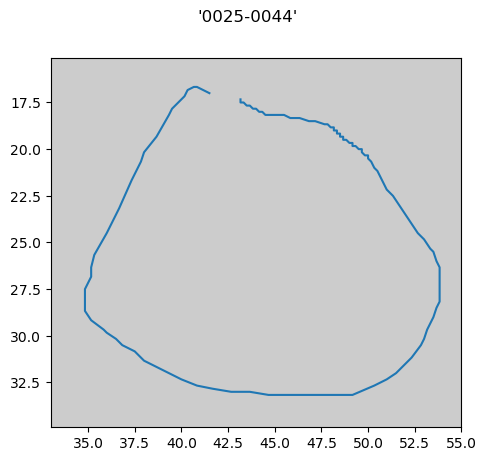

In [72]:
roi.plot()

In [14]:
roi.coordinates()

array([[43., 44.],
       [43., 58.],
       [67., 58.],
       [67., 44.],
       [43., 44.]], dtype=float32)

In [27]:


# Function to create ROI file content
def create_roi_file_content(contour):
    header = b'Iout'  # Magic identifier
    version = (217).to_bytes(2, 'big')  # ROI version
    type = (7).to_bytes(2, 'big')  # ROI type (polygon)
    n_coordinates = len(contour).to_bytes(2, 'big')
    top = min(contour[:, 1]).astype(int).to_bytes(2, 'big')
    left = min(contour[:, 0]).astype(int).to_bytes(2, 'big')
    bottom = (max(contour[:, 1]) + 1).astype(int).to_bytes(2, 'big')
    right = (max(contour[:, 0]) + 1).to_bytes(2, 'big')
    x1 = (0).to_bytes(4, 'big')
    y1 = (0).to_bytes(4, 'big')
    x2 = (0).to_bytes(4, 'big')
    y2 = (0).to_bytes(4, 'big')
    stroke_width = (0).to_bytes(2, 'big')
    shape_roi_size = (0).to_bytes(4, 'big')
    stroke_color = (0).to_bytes(4, 'big')
    fill_color = (0).to_bytes(4, 'big')
    subtype = (0).to_bytes(2, 'big')
    options = (0).to_bytes(2, 'big')
    arrow_style = (0).to_bytes(1, 'big')
    arrow_head_size = (0).to_bytes(1, 'big')
    rounded_rect_arc_size = (0).to_bytes(2, 'big')
    position = (0).to_bytes(4, 'big')
    header2offset = (0).to_bytes(2, 'big')
    roi_name_offset = (0).to_bytes(4, 'big')
    roi_name_size = (0).to_bytes(4, 'big')
    unused = (0).to_bytes(24, 'big')

    # Coordinates
    x_coordinates = (contour[:, 0] - min(contour[:, 0])).astype(int).tobytes()
    y_coordinates = (contour[:, 1] - min(contour[:, 1])).astype(int).tobytes()

    # Construct the ROI file content
    roi_content = (
        header + version + type + n_coordinates +
        top + left + bottom + right +
        x1 + y1 + x2 + y2 + stroke_width +
        shape_roi_size + stroke_color + fill_color +
        subtype + options + arrow_style + arrow_head_size +
        rounded_rect_arc_size + position + header2offset +
        roi_name_offset + roi_name_size + unused +
        x_coordinates + y_coordinates
    )
    
    return roi_content

# Function to save ROI to a zip file
def save_roi(zip_file, roi_content, name):
    with zipfile.ZipFile(zip_file, 'a') as zf:
        zf.writestr(name, roi_content)

# Iterate over the expt_IDs
for expt_ID in ['PS0000', 'ND0002', 'ND0003']:
    subset_df = df[df['Experiment ID'] == expt_ID]
    subset_df = subset_df[subset_df['Time (hours)'] == subset_df['Time (hours)'].max()]
    acq_IDs = subset_df['Acquisition ID'].unique()

    for acq_ID in acq_IDs:
        seg_fn = glob.glob(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/*/{acq_ID}.h5'))[0]
        # Read the segmentation and tracks
        with btrack.io.HDF5FileHandler(seg_fn, 'r', obj_type='obj_type_1') as reader:
            segmentation = reader.segmentation[-1]

        # Create a zip file for storing ROIs
        roi_zip_file = seg_fn.replace('macrohet_seg_model', 'ROI_zip').replace('h5', 'zip')
        os.makedirs(os.path.dirname(roi_zip_file), exist_ok=True)

        # Extract ROI points from the segmentation
        for seg_id in np.unique(segmentation):
            if seg_id == 0:
                continue

            instance_mask = segmentation == seg_id
            contours, _ = cv2.findContours(instance_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                contour = contours[0].reshape(-1, 2)
                roi_content = create_roi_file_content(contour)
                
                # Save ROI to zip file
                roi_name = f'{acq_ID}_seg_{seg_id}.roi'
                save_roi(roi_zip_file, roi_content, roi_name)

                # Save coordinates to CSV
                csv_file = roi_zip_file.replace('.zip', '_coordinates.csv')
                with open(csv_file, 'a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow(('x', 'y'))
                    for point in contour:
                        writer.writerow(point)

        print(f"ROIs and coordinates for {acq_ID} saved successfully.")

# Imports required for the script

[INFO][2024/05/31 05:47:58 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2024/05/31 05:48:07 PM] Loading segmentation (75, 6048, 6048)
[INFO][2024/05/31 05:48:07 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5


AttributeError: 'numpy.int64' object has no attribute 'to_bytes'

In [19]:
for expt_ID in ['PS0000', 'ND0002', 'ND0003']:
    subset_df = df[df['Experiment ID'] == expt_ID]
    subset_df = subset_df[subset_df['Time (hours)'] == subset_df['Time (hours)'].max()]
    acq_IDs = subset_df['Acquisition ID'].unique()
    
    for acq_ID in acq_IDs:
        seg_fn = glob.glob(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/*/{acq_ID}.h5'))[0]
        # Read the segmentation and tracks
        with btrack.io.HDF5FileHandler(seg_fn, 'r', obj_type='obj_type_1') as reader:
            segmentation = reader.segmentation[-1]
        
        # Create a zip file for storing ROIs
        roi_zip_file = seg_fn.replace('macrohet_seg_model', 'ROI_zip').replace('h5', 'zip')
        os.makedirs(os.path.dirname(roi_zip_file), exist_ok=True)

        # ssave segmentation out to roi zip file

[INFO][2024/05/31 05:36:26 PM] Opening HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5...
[INFO][2024/05/31 05:36:35 PM] Loading segmentation (75, 6048, 6048)
[INFO][2024/05/31 05:36:35 PM] Closing HDF file: /mnt/SYNO/macrohet_syno/PS0000/labels/macrohet_seg_model/(3, 4).h5


In [20]:
segmentation.shape

(6048, 6048)

In [22]:
seg_fn.replace('macrohet_seg_model', 'ROI_zip').replace('h5', 'zip')

'/mnt/SYNO/macrohet_syno/PS0000/labels/ROI_zip/(3, 4).zip'

In [8]:
for expt_ID in ['PS0000', 'ND0002', 'ND0003']:
    subset_df = df[df['Experiment ID'] == expt_ID]
    subset_df = subset_df[subset_df['Time (hours)'] == subset_df['Time (hours)'].max()]
    IDs = subset_df['ID'].unique()

    
    for ID in IDs:
        sc_df = subset_df[subset_df['ID'] == unique_ID]
        
        # get the acq id information
        acq_ID = row, column = int(unique_ID.split('.')[1]), int(unique_ID.split('.')[2])
        cell_ID = int(unique_ID.split('.')[0])
        expt_ID = unique_ID.split('.')[-1]

        # Read the segmentation and tracks
        with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/cpv3/{acq_ID}.h5'), 'r', obj_type='obj_type_1') as reader:
            segmentation = reader.segmentation
            tracks = reader.tracks

In [10]:
subset_df['ID'].unique()

array(['427.3.4.PS0000', '435.3.4.PS0000', '468.3.4.PS0000', ...,
       '740.6.9.PS0000', '865.6.9.PS0000', '935.6.9.PS0000'], dtype=object)

In [ ]:


# Function to save ROI to a zip file
def save_roi(zip_file, roi, name):
    with zipfile.ZipFile(zip_file, 'a') as zf:
        zf.writestr(name, roi.write_bytes())

# Iterate over all acq_ID and expt_ID
for unique_ID in tqdm(df['ID'].unique(), total=len(df['ID'].unique())):
    try:
        sc_df = df[df['ID'] == unique_ID]
        
        # get the acq id information
        acq_ID = row, column = int(unique_ID.split('.')[1]), int(unique_ID.split('.')[2])
        cell_ID = int(unique_ID.split('.')[0])
        expt_ID = unique_ID.split('.')[-1]

        # Read the segmentation and tracks
        with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/cpv3/{acq_ID}.h5'), 'r', obj_type='obj_type_1') as reader:
            segmentation = reader.segmentation
            tracks = reader.tracks

        # Create a zip file for storing ROIs
        roi_zip_file = f'/mnt/SYNO/macrohet_syno/{expt_ID}/roi/{acq_ID}_roi.zip'
        os.makedirs(os.path.dirname(roi_zip_file), exist_ok=True)

        # Iterate over each frame/data point
        for i, t in tqdm(enumerate(sc_df['Time (hours)']), total=len(sc_df), leave=False, desc=f'Creating ROI for {unique_ID}'):
            sc_df_t = sc_df[sc_df['Time (hours)'] == t]
            # Extract xy coordinates and transpose for python and area from the cell information
            y_coord, x_coord, area, t, f, mtb = sc_df_t.loc[:, ['x', 'y', 'Mphi Area (µm)', 'Time (hours)', 'Frame', 'Mtb Area (µm)']].values[0]

            # Scale according to tracking shrinkage
            y_coord, x_coord = y_coord * track_scale_factor, x_coord * track_scale_factor

            # Calculate the cropping boundaries
            x_start = int(x_coord - side_length / 2)
            x_end = int(x_coord + side_length / 2)
            y_start = int(y_coord - side_length / 2)
            y_end = int(y_coord + side_length / 2)
            
            # Pad the boundaries if they exceed the image dimensions
            if x_start < 0:
                x_pad = abs(x_start)
                x_start = 0
            else:
                x_pad = 0

            if x_end > segmentation.shape[0]:
                x_pad_end = x_end - segmentation.shape[0]
                x_end = segmentation.shape[0]
            else:
                x_pad_end = 0

            if y_start < 0:
                y_pad = abs(y_start)
                y_start = 0
            else:
                y_pad = 0

            if y_end > segmentation.shape[1]:
                y_pad_end = y_end - segmentation.shape[1]
                y_end = segmentation.shape[1]
            else:
                y_pad_end = 0

            # Crop the segmentation
            cropped_masks = segmentation[int(f), x_start:x_end, y_start:y_end]

            # Pad the cropped image if necessary
            cropped_masks = np.pad(cropped_masks, ((x_pad, x_pad_end), (y_pad, y_pad_end)), mode='constant')

            # Extract only that segment
            seg_ID = cropped_masks[int(cropped_masks.shape[0] / 2), int(cropped_masks.shape[1] / 2)]
            if seg_ID == 0:
                instance_mask = np.zeros((side_length, side_length), dtype=np.uint8)
            else:
                instance_mask = (cropped_masks == seg_ID).astype(np.uint8)

            # Find contours of the mask
            contours, _ = cv2.findContours(instance_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if contours:
                contour = contours[0].reshape(-1, 2)
                roi = ROI.frompoints(contour)
                save_roi(roi_zip_file, roi, f'{unique_ID}_{i}.roi')
        
        print(f"ROI for {unique_ID} saved successfully.")
    
    except Exception as e:
        error_message = f"Error: {e}\nUnique ID: {unique_ID}\n"
        with open("error_log.txt", "a") as file:
            file.write(error_message)

# I


# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
import os, glob
from macrohet import dataio, tile, visualise, notify
import numpy as np
from macrohet import visualise
import os
import re
import numpy as np
import cv2
import btrack
import zarr
from skimage import io
import cv2
from tqdm.auto import tqdm

def trim_black_borders(image):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding to get black areas
    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        cnt = max(contours, key=cv2.contourArea)  # find the largest contour
        x, y, w, h = cv2.boundingRect(cnt)
        image = image[y:y+h, x:x+w]
    return image

def crop_image_to_tiles(image, num_tiles_per_row, overlap_percentage):
    height, width, _ = image.shape

    # Calculate basic tile dimensions
    basic_tile_width = width // num_tiles_per_row
    basic_tile_height = height // num_tiles_per_row

    # Calculate the overlap in pixels
    overlap = int(overlap_percentage * basic_tile_width)

    # Calculate effective tile dimensions including overlap
    tile_width = basic_tile_width + overlap
    tile_height = basic_tile_height + overlap

    tiles = []
    for i in range(num_tiles_per_row):
        for j in range(num_tiles_per_row):
            # Calculate the position of the tile accounting for overlap
            left = max(0, i * basic_tile_width - overlap // 2)
            upper = max(0, j * basic_tile_height - overlap // 2)
            right = min(width, left + tile_width)
            lower = min(height, upper + tile_height)
            
            # Crop the tile
            crop = image[upper:lower, left:right]
            tiles.append(crop)

    return tiles

num_tiles_per_row = 3
overlap_percentage =0.1

tile_position_mapping_dictionary = {1:2, 
                                   2:7, 
                                   3:8, 
                                   4:3, 
                                   5:6, 
                                   6:9, 
                                   7:4, 
                                   8:5,
                                   9:1}

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [2]:
%%time
expt_ID = 'ND0003'

base_dir = f'/mnt/SYNO/macrohet_syno/{expt_ID}/'
# base_dir = f'/mnt/DATA/macrohet/{expt_ID}/'

metadata_fn = glob.glob(os.path.join(base_dir, 'acquisition/Images/Index*xml'))[0]
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


0it [00:00, ?it/s]

Extracting metadata complete!
CPU times: user 32.4 s, sys: 2.67 s, total: 35.1 s
Wall time: 35 s


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0301K1F1P1R1,Ok,r03c01f01p01-ch1sk1fk1fl1.tiff,3,1,1,1,0,1,1,...,0,0.135256499,0,2024-02-16T17:15:25.597+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
1,0301K1F1P1R2,Ok,r03c01f01p01-ch2sk1fk1fl1.tiff,3,1,1,1,0,2,1,...,0,0.135256499,0,2024-02-16T17:15:25.813+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
2,0301K1F1P2R1,Ok,r03c01f01p02-ch1sk1fk1fl1.tiff,3,1,1,2,0,1,1,...,2E-06,0.1352586,0,2024-02-16T17:15:26.157+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
3,0301K1F1P2R2,Ok,r03c01f01p02-ch2sk1fk1fl1.tiff,3,1,1,2,0,2,1,...,2E-06,0.1352586,0,2024-02-16T17:15:26.39+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
4,0301K1F1P3R1,Ok,r03c01f01p03-ch1sk1fk1fl1.tiff,3,1,1,3,0,1,1,...,4E-06,0.135260597,0,2024-02-16T17:15:26.733+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349267,0612K154F9P1R2,Ok,r06c12f09p01-ch2sk154fk1fl1.tiff,6,12,9,1,153,2,1,...,0,0.135008901,275402.773,2024-02-19T21:59:46.84+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349268,0612K154F9P2R1,Ok,r06c12f09p02-ch1sk154fk1fl1.tiff,6,12,9,2,153,1,1,...,2E-06,0.135010898,275402.773,2024-02-19T21:59:47.183+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349269,0612K154F9P2R2,Ok,r06c12f09p02-ch2sk154fk1fl1.tiff,6,12,9,2,153,2,1,...,2E-06,0.135010898,275402.773,2024-02-19T21:59:47.4+00:00,488,522,40,1.1,0.1,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."
349270,0612K154F9P3R1,Ok,r06c12f09p03-ch1sk154fk1fl1.tiff,6,12,9,3,153,1,1,...,4E-06,0.135012895,275402.773,2024-02-19T21:59:47.743+00:00,640,706,40,1.1,0.2,"[[0.999464,0,0,-5.0],[0,-0.999464,0,4.1],[0,0,..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [3]:
metadata_path = glob.glob(os.path.join(base_dir, 'acquisition/Assaylayout/*.xml'))[0]
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC  Replicate #
Row Column                                                           
3   1         UNI     CTRL             0             EC0            1
    2         UNI     CTRL             0             EC0            2
    3          WT     CTRL             0             EC0            1
    4          WT     CTRL             0             EC0            2
    5          WT      PZA            60            EC50            1
    6          WT      PZA            60            EC50            2
    7          WT      RIF           0.1            EC50            1
    8          WT      RIF           0.1            EC50            2
    9          WT      INH          0.04            EC50            1
    10         WT      INH          0.04            EC50            2
    11         WT      BDQ          0.02            EC50            1
    12         WT      BDQ          0.02            EC50            2
4   3          WT     CTRL             0             EC0            3
    4          WT     CTRL             0             EC0            4
    5          WT      PZA           400            EC99            1
    6          WT      PZA           400            EC99            2
    7          WT      RIF             2            EC99            1
    8          WT      RIF             2            EC99            2
    9          WT      INH             2            EC99            1
    10         WT      INH             2            EC99            2
    11         WT      BDQ           2.5            EC99            1
    12         WT      BDQ           2.5            EC99            2
5   3         RD1     CTRL             0             EC0            1
    4         RD1     CTRL             0             EC0            2
    5         RD1      PZA            60            EC50            1
    6         RD1      PZA            60            EC50            2
    7         RD1      RIF           0.1            EC50            1
    8         RD1      RIF           0.1            EC50            2
    9         RD1      INH          0.04            EC50            1
    10        RD1      INH          0.04            EC50            2
    11        RD1      BDQ          0.02            EC50            1
    12        RD1      BDQ          0.02            EC50            2
6   3         RD1     CTRL             0             EC0            3
    4         RD1     CTRL             0             EC0            4
    5         RD1      PZA           400            EC99            1
    6         RD1      PZA           400            EC99            2
    7         RD1      RIF             2            EC99            1
    8         RD1      RIF             2            EC99            2
    9         RD1      INH             2            EC99            1
    10        RD1      INH             2            EC99            2
    11        RD1      BDQ           2.5            EC99            1
    12        RD1      BDQ           2.5            EC99            2

### Iterate and save out 

In [4]:
for acq_ID, info in tqdm(assay_layout.iterrows(), total = len(assay_layout)):
    # if acq_ID != (5, 7):
    #     continue
    # if acq_ID == (6, 3):
    #     continue
    output_basedir = os.path.join(base_dir, F'postfix/labelled_tracks_final_frame/{acq_ID}')
    if os.path.exists(output_basedir): 
        # print('rewriting anyway')
        continue    
    try:
        os.makedirs(output_basedir, exist_ok=True)  # Make sure the base directory exists
    
        cropped_metadata = metadata[(metadata['Row'] == str(acq_ID[0]))
                                    & (metadata['Col'] == str(acq_ID[1]))
                                    & (metadata['TimepointID'] == str(metadata['TimepointID'].astype(int).max()))
                                    & (metadata['ChannelID'] == '2')
                                    & (metadata['PlaneID'] == '1')
                                    ]
        
        
        image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
        zarr_group = zarr.open(image_dir, mode='r')

        num_frames = zarr_group.images.shape[0]
        # Initialize the index to the last frame
        index = -1
        
        # Loop until a frame without all zeros is found
        while index >= -num_frames:  # Ensure index stays within bounds
            images = zarr_group.images[index, :, 0, ...]
            if not np.all(images == 0):
                break
            index -= 1
        
        if index >= -num_frames:
            # Convert the negative index to a positive frame number
            frame_number = index if index >= 0 else num_frames + index
            print(f"Found a non-zero frame at frame number {frame_number}")
        else:
            print("All frames contain only zeros")
        
        viewer = napari.Viewer(title = f'{expt_ID, acq_ID}')
        
        viewer.add_image(images,
                         channel_axis = 0, 
                         # # scale = napari_scale, 
                         contrast_limits=[[280, 1000],[0,3000]])
        
        with btrack.io.HDF5FileHandler(os.path.join(f'/mnt/SYNO/macrohet_syno/{expt_ID}/labels/cpv3/{acq_ID}.h5'), 
                                                   'r', 
                                                   obj_type='obj_type_1'
                                                   ) as reader:
                        segmentation = reader.segmentation
                        tracks = reader.tracks
        
        last_frame_tracks = [t for t in tracks if t.in_frame(149) and len(t) >= 70]
        coords = [(int(t.y[-1]*5.04), int(t.x[-1]*5.04)) for t in last_frame_tracks]
        # Assuming last_frame_tracks is a list of objects with attributes ID, x, and y
        id_xy_dict = [{'ID':t.ID, 
                      'x':int(t.x[-1]*5.04),
                      'y':int(t.y[-1]*5.04)} for t in last_frame_tracks]
        
        ### JUST IDs
        text_parameters = {
            'string': '{ID}',
            'size': 9,
            'color': 'white',
            'anchor': 'center',
            # 'translation': [-3, 0],
        }
        viewer.add_points(coords, size = 150, face_color='transparent', edge_color='transparent', edge_width=0.1, 
                          properties = id_xy_dict,
                          text = text_parameters)
        output_fn = f'{acq_ID}_{expt_ID}_t{index}_IDs.png'
        output_path = os.path.join(output_basedir, 'tiled', output_fn)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Make sure the directory exists
        screen_shot = trim_black_borders(viewer.screenshot())
        io.imsave(output_path, screen_shot)
        tiles = crop_image_to_tiles(screen_shot, 3, 0.1)
        for i, tile in enumerate(tiles): 
            FieldID = tile_position_mapping_dictionary[i+1]
            tile_fn = cropped_metadata[cropped_metadata['FieldID'] == str(FieldID)]['URL'].iloc[0]
            directory, old_filename = os.path.split(output_path)
            new_filename = f"{tile_fn}_{old_filename}"
            new_directory = directory.replace('tiled', 'untiled')    
            new_path = os.path.join(new_directory, new_filename)
            os.makedirs(os.path.dirname(new_path), exist_ok=True)  # Make sure the directory exists
            io.imsave(new_path, tile)
        del viewer.layers['Points']
        
        ### IDs and COORDS
        text_parameters = {
            'string': '{ID}\n{x},{y}',
            'size': 9,
            'color': 'white',
            'anchor': 'center',
            # 'translation': [-3, 0],
        }
        viewer.add_points(coords, size = 150, face_color='transparent', edge_color='transparent', edge_width=0.1, 
                          properties = id_xy_dict,
                          text = text_parameters)
        output_fn = f'{acq_ID}_{expt_ID}_t-1_IDs_xy.png'
        output_path = os.path.join(output_basedir, 'tiled/with_xy_coords', output_fn)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Make sure the directory exists
        screen_shot = trim_black_borders(viewer.screenshot())
        io.imsave(output_path, screen_shot)
        tiles = crop_image_to_tiles(screen_shot, 3, 0.1)
        for i, tile in enumerate(tiles): 
            FieldID = tile_position_mapping_dictionary[i+1]
            tile_fn = cropped_metadata[cropped_metadata['FieldID'] == str(FieldID)]['URL'].iloc[0]
            directory, old_filename = os.path.split(output_path)
            new_filename = f"{tile_fn}_{old_filename}"
            new_directory = directory.replace('tiled', 'untiled')    
            new_path = os.path.join(new_directory, new_filename)
            os.makedirs(os.path.dirname(new_path), exist_ok=True)  # Make sure the directory exists
            io.imsave(new_path, tile)
        del viewer.layers['Points']
        
        ### IDs with MASKS
        text_parameters = {
            'string': '{ID}',
            'size': 9,
            'color': 'white',
            'anchor': 'center',
            # 'translation': [-3, 0],
        }
        viewer.add_points(coords, size = 150, face_color='transparent', edge_color='transparent', edge_width=0.1, 
                          properties = id_xy_dict,
                          text = text_parameters)
        viewer.add_labels(segmentation[-1])
        viewer.layers['Labels'].contour = 10
        output_fn = f'{acq_ID}_{expt_ID}_t-1_IDs_masks.png'
        output_path = os.path.join(output_basedir, 'tiled/with_masks', output_fn)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Make sure the directory exists
        screen_shot = trim_black_borders(viewer.screenshot())
        io.imsave(output_path, screen_shot)
        tiles = crop_image_to_tiles(screen_shot, 3, 0.1)
        for i, tile in enumerate(tiles): 
            FieldID = tile_position_mapping_dictionary[i+1]
            tile_fn = cropped_metadata[cropped_metadata['FieldID'] == str(FieldID)]['URL'].iloc[0]
            directory, old_filename = os.path.split(output_path)
            new_filename = f"{tile_fn}_{old_filename}"
            new_directory = directory.replace('tiled', 'untiled')    
            new_path = os.path.join(new_directory, new_filename)
            os.makedirs(os.path.dirname(new_path), exist_ok=True)  # Make sure the directory exists
            io.imsave(new_path, tile)
        del viewer.layers['Points']
        
        ### IDs and COORDS and masks
        text_parameters = {
            'string': '{ID}\n{x},{y}',
            'size': 9,
            'color': 'white',
            'anchor': 'center',
            # 'translation': [-3, 0],
        }
        viewer.add_points(coords, size = 150, face_color='transparent', edge_color='transparent', edge_width=0.1, 
                          properties = id_xy_dict,
                          text = text_parameters)
        # viewer.add_labels(segmentation[-1])
        # viewer.layers['Labels'].contour = 10
        output_fn = f'{acq_ID}_{expt_ID}_t-1_IDs_xy_masks.png'
        output_path = os.path.join(output_basedir, 'tiled/with_xy_coords_masks', output_fn)
        os.makedirs(os.path.dirname(output_path), exist_ok=True)  # Make sure the directory exists
        screen_shot = trim_black_borders(viewer.screenshot())
        io.imsave(output_path, screen_shot)
        tiles = crop_image_to_tiles(screen_shot, 3, 0.1)
        for i, tile in enumerate(tiles): 
            FieldID = tile_position_mapping_dictionary[i+1]
            tile_fn = cropped_metadata[cropped_metadata['FieldID'] == str(FieldID)]['URL'].iloc[0]
            directory, old_filename = os.path.split(output_path)
            new_filename = f"{tile_fn}_{old_filename}"
            new_directory = directory.replace('tiled', 'untiled')    
            new_path = os.path.join(new_directory, new_filename)
            os.makedirs(os.path.dirname(new_path), exist_ok=True)  # Make sure the directory exists
            io.imsave(new_path, tile)
        del viewer.layers['Points']
        del viewer.layers['Labels']
        viewer.close()

    except:
        print('Issue with:', acq_ID)

    # break

  0%|          | 0/42 [00:00<?, ?it/s]

Found a non-zero frame at frame number 149


[INFO][2024/05/20 04:45:36 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 3).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 3).h5...
[INFO][2024/05/20 04:45:58 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/05/20 04:45:58 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/05/20 04:45:58 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/05/20 04:45:58 pm] Loading objects/obj_type_1 (22676, 5) (22676 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (22676, 5) (22676 filtered: None)
[INFO][2024/05/20 04:45:58 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 3).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 3).h5


Found a non-zero frame at frame number 152


[INFO][2024/05/20 04:46:28 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 4).h5...
[INFO][2024/05/20 04:46:48 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/05/20 04:46:48 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/05/20 04:46:48 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/05/20 04:46:49 pm] Loading objects/obj_type_1 (43524, 5) (43524 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (43524, 5) (43524 filtered: None)
[INFO][2024/05/20 04:46:50 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 4).h5


Found a non-zero frame at frame number 152


[INFO][2024/05/20 04:47:20 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 5).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 5).h5...
[INFO][2024/05/20 04:47:40 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/05/20 04:47:40 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/05/20 04:47:40 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/05/20 04:47:40 pm] Loading objects/obj_type_1 (36412, 5) (36412 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (36412, 5) (36412 filtered: None)
[INFO][2024/05/20 04:47:41 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 5).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 5).h5


Found a non-zero frame at frame number 152


[INFO][2024/05/20 04:48:11 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 6).h5...
[INFO][2024/05/20 04:48:31 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/05/20 04:48:32 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/05/20 04:48:32 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/05/20 04:48:32 pm] Loading objects/obj_type_1 (42213, 5) (42213 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (42213, 5) (42213 filtered: None)
[INFO][2024/05/20 04:48:33 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 6).h5


Found a non-zero frame at frame number 152


[INFO][2024/05/20 04:49:02 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 7).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 7).h5...
[INFO][2024/05/20 04:49:22 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/05/20 04:49:22 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/05/20 04:49:22 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/05/20 04:49:23 pm] Loading objects/obj_type_1 (39242, 5) (39242 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39242, 5) (39242 filtered: None)
[INFO][2024/05/20 04:49:23 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 7).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 7).h5


Found a non-zero frame at frame number 153


[INFO][2024/05/20 04:49:52 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 8).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 8).h5...
[INFO][2024/05/20 04:50:13 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/05/20 04:50:13 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/05/20 04:50:13 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/05/20 04:50:13 pm] Loading objects/obj_type_1 (43238, 5) (43238 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (43238, 5) (43238 filtered: None)
[INFO][2024/05/20 04:50:14 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 8).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/ND0003/labels/cpv3/(5, 8).h5
